# Автокорреляционная и разностные функции

* Стандартная форма, с постоянным пределом интегрирования:
    $$r_t(\tau) = \sum_{i=t+1}^{W+t} x(i)\cdot x(i+\tau)$$
* Рекурентное соотношение:
    $$r_t(\tau) = r_{t-1}(\tau) + x(t+W)\cdot x(t+W+\tau) - x(t)\cdot x(t+\tau)$$
* Разностная функция
    $$d_t(\tau) = \sum_{i=t+1}^{t+W} (x(i) - x(i+\tau))^2$$
* Она выражается через АКФ
    $$d_t(\tau) = r_t(0) + r_{t+\tau}(0) - 2r_t(\tau)$$
Этот факт потом используется в реализации (см. код), здесь обе функции посчитаны согласно определению.
* Пример подсчета АКФ и разностной функции для струны A2 гитары:
(должны наблюдаться максимумы $\tau \approx k \cdot 9.6 \text{ms}, \quad k \in \mathbb{N}$), тут гитара немного
растроена)

## Код на python


In [54]:
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
from math import ceil
plt.rc('text', usetex=True)
def short_time_acf(x, W, time, max_period):
    x1 = x[time:time+W]
    acf = np.empty(max_period,dtype='int64')
    for lag in range(max_period):
        x2 = x[time+lag:time+lag+W]
        acf[lag] = np.sum(x1*x2)
    return acf 

def diff_function(x, W, time, max_period):
    x1 = x[time:time+W]
    d = np.empty(max_period,dtype='int64')
    for lag in range(max_period):
        x2 = x[time+lag:time+lag+W]
        d[lag] = np.sum((x1-x2)**2)
    return d

## Считывание амплитуд

Звук струны записан в WAV файл

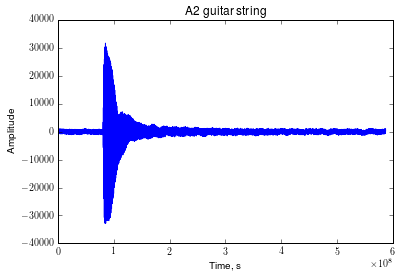

In [9]:
(rate, data) = wavfile.read("./A2.wav")
data = data.astype('int64') #to prevent overflow
N = data.size
time = np.arange(N) * rate #in seconds
plt.title("A2 guitar string")
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.plot(time,data)
plt.show()

## АКФ

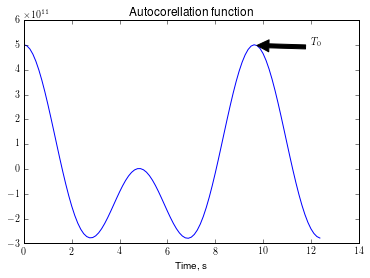

In [29]:
moment = 1 #sec
min_freq = 80 #Hz
max_period = ceil(rate / min_freq) # in samples
ac = short_time_acf(data, 4096, moment * rate, max_period)
time = np.arange(0, max_period) / rate * 1000 #ms
plt.xlabel("lag, s")
plt.title("Autocorellation function")
plt.plot(time, ac)
plt.annotate('$T_0$', xy=(9.62359, 4.984*10**11), xytext=(12, 5*10**11),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

Понятно, что у АКФ должен быть максимум в точках, которые кратны основному периоду.

## Разностная функция

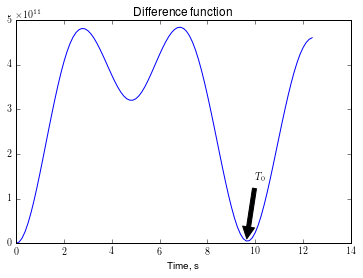

In [30]:
d = diff_function(data, 4096, 12000, max_period)
plt.xlabel("lag, s")
plt.title("Difference function")
plt.plot(time, d)
plt.annotate('$T_0$', xy=(9.62359, 3.5*10**9), xytext=(10, 14*10**10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.show()

А у разностной функции должен наблюдаться минимум в точках, которые кратны основному периоду.

# Нормировка разностной функции
В [статье](http://recherche.ircam.fr/equipes/pcm/cheveign/ps/2002_JASA_YIN_proof.pdf) предлагается такая нормировка:
$$
d'_t(\tau)=
\begin{cases}
1, \tau = 0\\
\frac{d_t(\tau)}{\frac{1}{\tau} \sum_{i=1}^{\tau}d_t(i)}
\end{cases}
$$
## Код на python

In [31]:
def diff_norm(d):
    d_normed = np.empty(d.size)
    d_normed[0] = 1
    running_sum = 0
    for j in range(1,d.size):
        running_sum  += d[j]
        d_normed[j] = d[j] * j / running_sum
    return d_normed
        

## Нормированная разностная функция

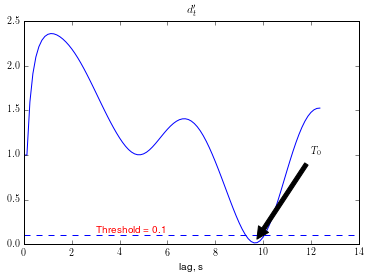

In [53]:
d_normed = diff_norm(d)
time = np.arange(0, max_period) / rate * 1000 #ms
plt.xlabel("lag, s")
plt.title("$d'_t$")
plt.plot(time, d_normed)
plt.annotate('$T_0$', xy=(9.62359, 0.01), xytext=(12, 1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot((0,14), (0.1, 0.1), 'b--')
plt.text(3,0.13,"Threshold = 0.1",color='r')
plt.show()